# ***Introducing the project***
####  <strong>Accurate traffic classification</strong> is fundamentally important for various network activities such as network management and resource utilisation. Port-based approaches, deep packet inspection and machine learning are widely used techniques to classify and analyze network traffic flows. However, over the past several years, the growth of Internet traffic has been explosive due to the greatly increased number of Internet users. Therefore, both port-based and deep packet inspection approaches have become inefficient due to the exponential growth of the Internet applications that incurs high computational cost. The emerging paradigm of software-defined networking has reshaped the network architecture by detaching the control plane from the data plane to result in a centralised network controller that maintains a global view over the whole network on its domain. 

#### This project aims to ***implement a Deep Learning model for software-defined networks*** that can accurately identify a the nature of an SDN packet wether it was a normal or abnormal tarffic and therefore helping Network Administrators in detecting potential attacks.

#### Using python <a href="https://ryu-sdn.org/">RYU</a> and <a href="http://mininet.org/">Miniet</a>, we were able to generate a random SDN traffic dataset containing more than 100,000 rows in both normal packets(1 labels) and abnormal packets (0 labels)

#### We were able to reach a 98.38% accuracy on the test set with a total of 92,769 trainable parameters


## ***Load packages***

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## ***Load the SDN traffic dataset***

In [2]:
df = pd.read_csv('/content/drive/MyDrive/SDN/sdn_traffic_dataset.csv')
df.shape

(104345, 23)

In [3]:
df.sample(6)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
22703,3369,3,10.0.0.2,10.0.0.5,97422,103851852,215,258000000,2.150000e+11,6,7916,13529,14421914,450,0,UDP,3,603594916,5312,7965,0.0,7965.0,0
87734,30741,3,10.0.0.14,10.0.0.10,121658,126767636,443,38000000,4.430000e+11,7,4920,7915,8247430,263,1,ICMP,3,133889911,249188001,0,2232.0,2232.0,1
43972,31543,6,10.0.0.12,10.0.0.1,93323,102505182,210,475000000,2.100000e+11,9,18351,13312,14606512,443,1,TCP,1,7535090,6994400,0,0.0,0.0,0
59580,33933,4,10.0.0.7,10.0.0.5,134,13132,138,171000000,1.380000e+11,9,3034,29,2842,0,1,ICMP,1,19143,15046,0,0.0,0.0,0
485,9846,1,10.0.0.1,10.0.0.7,6002,6398132,13,242000000,1.324200e+10,2,1910,0,0,0,0,UDP,1,3542,6470592,0,1725.0,1725.0,1
61750,29112,3,10.0.0.3,10.0.0.7,204,19992,210,127000000,2.100000e+11,6,1057,29,2842,0,1,ICMP,1,4555,1242,0,0.0,0.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [5]:
df.isna().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

👉 We found two columns that contain 506 NA values : "rx_kbps" and "tot_kbps"

## ***Basic Data Cleaning***

In [6]:
df.dropna(inplace=True)
df.isna().sum()

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

In [7]:
df.shape

(103839, 23)

## ***Next, let's drop all the unuseful information***
👉 We will be dropping the ID and switch number columns as well as the source and destination IP addresses and the port number as they are not relevant to the prediction

In [8]:
df.drop(['dt', 'switch', 'src', 'dst','port_no'], axis=1, inplace=True)
df.head()

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,143928631,3917,0,0.0,0.0,0
1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,3842,3520,0,0.0,0.0,0
2,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3795,1242,0,0.0,0.0,0
3,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3688,1492,0,0.0,0.0,0
4,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3413,3665,0,0.0,0.0,0


In [9]:
df.shape

(103839, 18)

## ***Next, we will be creating dummy variables for the Protocol column to make our algorithm more efficient***

In [10]:
df.Protocol.unique()

array(['UDP', 'TCP', 'ICMP'], dtype=object)

In [11]:
df = pd.get_dummies(df)

In [12]:
df.head()

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,Protocol_ICMP,Protocol_TCP,Protocol_UDP
0,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,143928631,3917,0,0.0,0.0,0,0,0,1
1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,3842,3520,0,0.0,0.0,0,0,0,1
2,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3795,1242,0,0.0,0.0,0,0,0,1
3,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3688,1492,0,0.0,0.0,0,0,0,1
4,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3413,3665,0,0.0,0.0,0,0,0,1


## ***Next, we will apply a MinMax Scaler to standardize our dataset and make all values in range (0,1)***

In [13]:
scaler = MinMaxScaler()

In [14]:
df_std= scaler.fit_transform(df)
df_std

array([[1.74242133e-01, 3.28245224e-01, 5.31632111e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.86123397e-01, 9.15781280e-01, 1.48856991e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.47426598e-01, 6.54497966e-01, 1.06326422e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.19228018e-04, 2.06486866e-05, 1.64805954e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.19228018e-04, 2.06486866e-05, 1.64805954e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.19228018e-04, 2.06486866e-05, 1.64805954e-02, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [15]:
df_std.shape

(103839, 20)

In [16]:
new_df = pd.DataFrame(df_std, columns=df.columns)

In [17]:
new_df.head()

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,Protocol_ICMP,Protocol_TCP,Protocol_UDP
0,0.174242,0.328245,0.053163,0.716717,0.053723,0.066667,0.076883,0.962331,0.996744,0.96243,0.0,1.133295e-01,3.090061e-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.486123,0.915781,0.148857,0.734735,0.149468,0.000000,0.076883,0.962304,0.996717,0.96243,0.0,1.035450e-06,2.689292e-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.347427,0.654498,0.106326,0.744745,0.106915,0.066667,0.076883,0.962324,0.996737,0.96243,0.0,9.984414e-07,3.896647e-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.347427,0.654498,0.106326,0.744745,0.106915,0.066667,0.076883,0.962324,0.996737,0.96243,0.0,9.141880e-07,6.420382e-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.347427,0.654498,0.106326,0.744745,0.106915,0.066667,0.076883,0.962324,0.996737,0.96243,0.0,6.976491e-07,2.835669e-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
new_df.shape

(103839, 20)

In [37]:
new_df['class'] = new_df['label']
del new_df['label']

In [38]:
new_df.shape

(103839, 20)

In [39]:
new_df.head()

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,Protocol_ICMP,Protocol_TCP,Protocol_UDP,class
0,0.174242,0.328245,0.053163,0.716717,0.053723,0.066667,0.076883,0.962331,0.996744,0.96243,0.0,1.133295e-01,3.090061e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.486123,0.915781,0.148857,0.734735,0.149468,0.000000,0.076883,0.962304,0.996717,0.96243,0.0,1.035450e-06,2.689292e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.347427,0.654498,0.106326,0.744745,0.106915,0.066667,0.076883,0.962324,0.996737,0.96243,0.0,9.984414e-07,3.896647e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.347427,0.654498,0.106326,0.744745,0.106915,0.066667,0.076883,0.962324,0.996737,0.96243,0.0,9.141880e-07,6.420382e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.347427,0.654498,0.106326,0.744745,0.106915,0.066667,0.076883,0.962324,0.996737,0.96243,0.0,6.976491e-07,2.835669e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## ***Next, we will be spliting our dataset into input X and output Y variables***

In [40]:
X = new_df.iloc[:,1:19].astype(float)
y = new_df.iloc[:,-1]

In [41]:
X.shape

(103839, 18)

In [42]:
y.shape

(103839,)

## ***Next, we will be spliting our dataset into a training set (80%) and a test set (20%)***

In [43]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## ***First, we started by defining our Neural Network model***

In [45]:
model = Sequential()
model.add(Dense(32, input_shape=(18,), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [44]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation

# model = Sequential([
#     Dense(2048, input_shape=(19,), activation='relu'),
#     BatchNormalization(),
#     Activation('relu'),
#     Dropout(0.5),
#     Dense(1024, activation='relu'),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(1024, activation='relu'),
#     BatchNormalization(),
#     Activation('relu'),
#     Dropout(0.5),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Activation('relu'),
#     Dense(1, activation='softmax')
# ])

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                608       
_________________________________________________________________
dense_11 (Dense)             (None, 512)               16896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

## ***Before moving further, we defined an early stopping callback***

In [47]:
# This callback will stop the training when there is no improvement in the validation loss for 5 consecutive epochs.  
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=5,
    restore_best_weights=True
)

## ***We used binary crosentropy to calculate the loss at each epoch of training and Adam optimizer for the optimization***

In [48]:
model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

## ***We trained our model***

In [49]:
model.fit(X_train, 
          y_train, 
          epochs=30,
          batch_size=250, 
          verbose=1, 
          validation_split=0.2,
          callbacks=[es])

Epoch 1/30
266/266 [==============================] - 5s 15ms/step - loss: 0.3439 - accuracy: 0.8260 - val_loss: 0.4333 - val_accuracy: 0.7431
Epoch 2/30
266/266 [==============================] - 4s 14ms/step - loss: 0.1689 - accuracy: 0.9254 - val_loss: 0.2414 - val_accuracy: 0.8737
Epoch 3/30
266/266 [==============================] - 4s 13ms/step - loss: 0.1447 - accuracy: 0.9379 - val_loss: 0.1210 - val_accuracy: 0.9488
Epoch 4/30
266/266 [==============================] - 4s 14ms/step - loss: 0.1319 - accuracy: 0.9435 - val_loss: 0.1272 - val_accuracy: 0.9481
Epoch 5/30
266/266 [==============================] - 4s 15ms/step - loss: 0.1231 - accuracy: 0.9475 - val_loss: 0.1208 - val_accuracy: 0.9427
Epoch 6/30
266/266 [==============================] - 4s 14ms/step - loss: 0.1191 - accuracy: 0.9499 - val_loss: 0.0971 - val_accuracy: 0.9586
Epoch 7/30
266/266 [==============================] - 4s 14ms/step - loss: 0.1158 - accuracy: 0.9516 - val_loss: 0.1023 - val_accuracy: 0.9568

In [51]:
history_dict = model.history.history

## ***Using the model history, we plotted the loss and the accuracy of both training and validation sets***

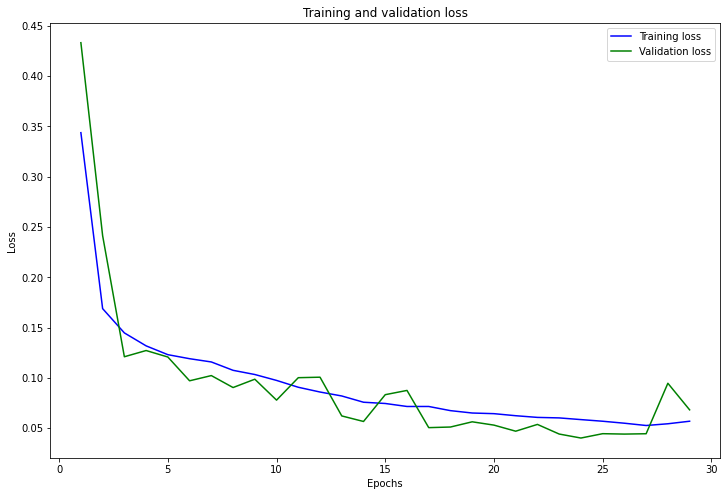

In [55]:
# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1) 

# plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss_values, 'blue',label='Training loss')
plt.plot(epochs, val_loss_values, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

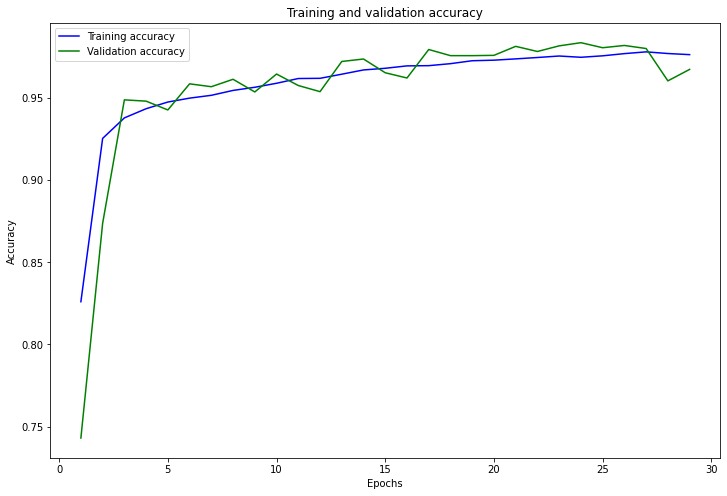

In [57]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'blue',label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## ***Next, we evaluated the test set accuracy***

In [59]:
results = model.evaluate(X_test, y_test, batch_size=250)
print("Test set accuracy = {} %".format( results[1]*100))

84/84 [==============================] - 0s 3ms/step - loss: 0.0400 - accuracy: 0.9839
Test set accuracy = 98.38694334030151 %


## ***finally, we looked at the confusion matrix***

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


preds = np.round(model.predict(X_test),0)

print(confusion_matrix(y_test, preds)) 

[[12379   234]
 [  101  8054]]
